Primeiras linhas:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies   

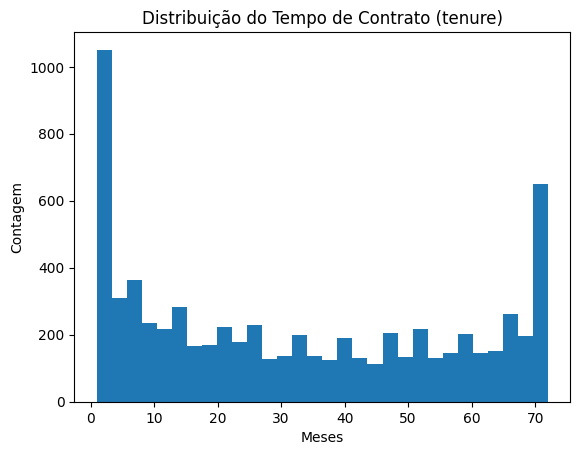

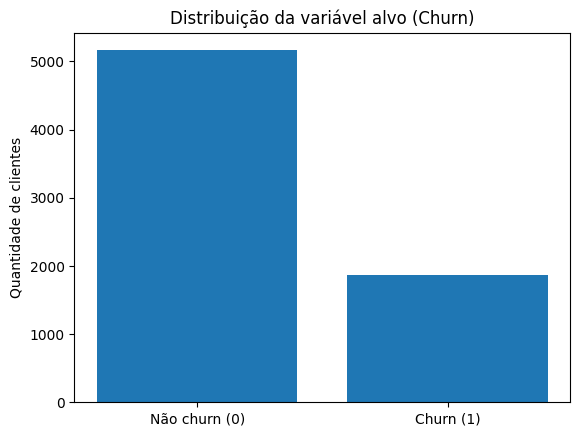


Tamanho treino: (4922, 19)
Tamanho teste : (2110, 19)

Colunas numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Colunas categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Treinando GridSearch para Regressão Logística...
Melhores parâmetros (LogReg): {'classifier__C': 1}

Treinando GridSearch para Random Forest...
Melhores parâmetros (RandomForest): {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

===== AVALIAÇÃO: Regressão Logística =====
Accuracy : 0.7365
Precision: 0.5028
Recall   : 0.7932
F1-score : 0.6155

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1549
           1       0.50      0.79      0.62       561

    accuracy       

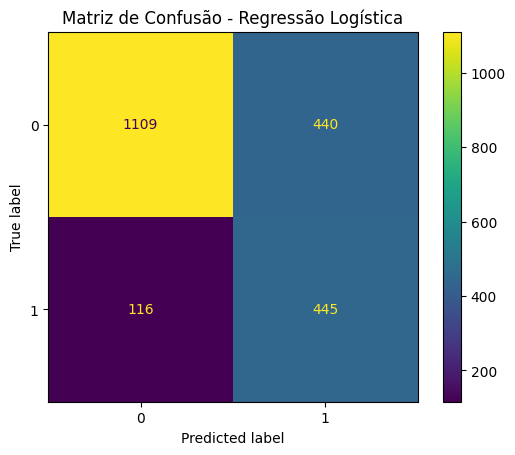

ROC AUC  : 0.8377


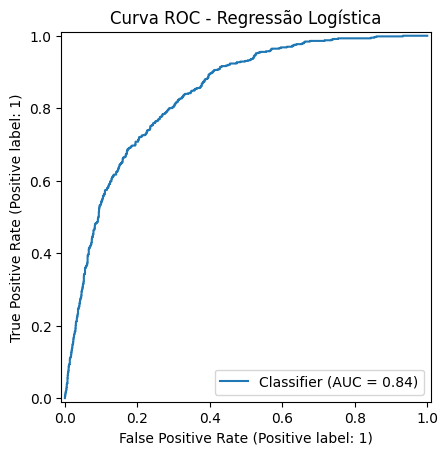

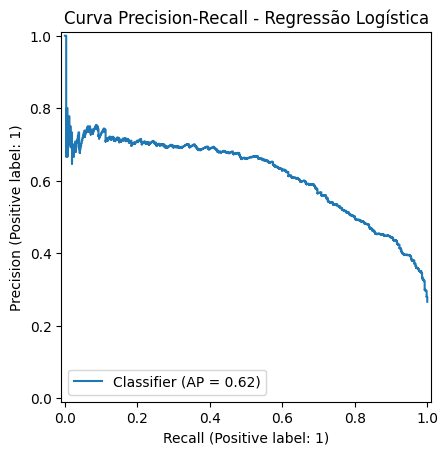


===== AVALIAÇÃO: Random Forest =====
Accuracy : 0.728
Precision: 0.4927
Recall   : 0.779
F1-score : 0.6036

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1549
           1       0.49      0.78      0.60       561

    accuracy                           0.73      2110
   macro avg       0.70      0.74      0.70      2110
weighted avg       0.79      0.73      0.74      2110



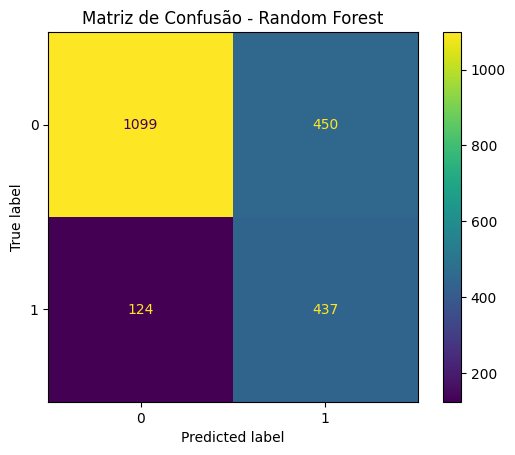

ROC AUC  : 0.8351


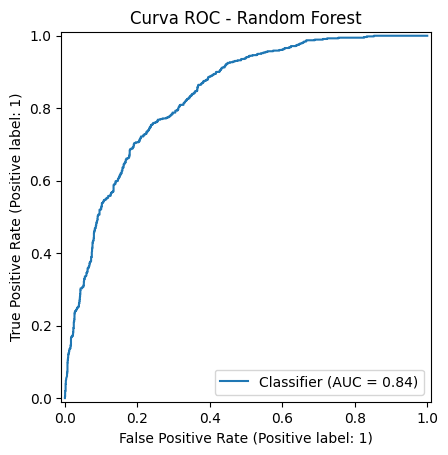

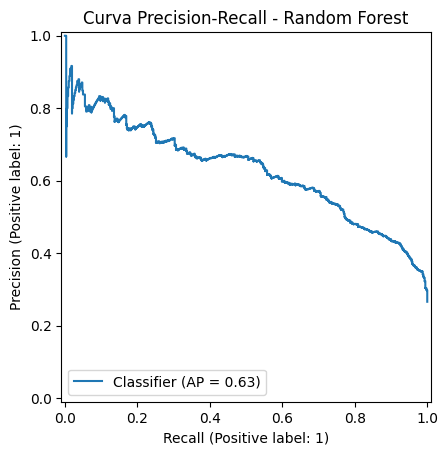


===== TABELA COMPARATIVA DE MÉTRICAS =====
                modelo  accuracy  precision    recall        f1   roc_auc
0  Regressão Logística  0.736493   0.502825  0.793226  0.615491  0.837737
1        Random Forest  0.727962   0.492672  0.778966  0.603591  0.835059

Top 20 features com maior |coef| (Regressão Logística):
                                      feature      coef  coef_abs
1                                 num__tenure -1.338019  1.338019
38                     cat__Contract_Two year -0.753218  0.753218
3                           num__TotalCharges  0.694352  0.694352
36               cat__Contract_Month-to-month  0.641260  0.641260
16           cat__InternetService_Fiber optic  0.594200  0.594200
15                   cat__InternetService_DSL -0.547184  0.547184
2                         num__MonthlyCharges -0.511908  0.511908
12                      cat__MultipleLines_No -0.249379  0.249379
25  cat__DeviceProtection_No internet service -0.244460  0.244460
17               

In [ ]:
# ============================================
# 1. IMPORTAÇÕES
# ============================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

RANDOM_STATE = 42


# ============================================
# 2. CARREGAR DATASET TELCO DA IBM
# ============================================
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("Primeiras linhas:")
print(df.head())

print("\nInfo geral:")
print(df.info())


# ============================================
# 3. AJUSTES INICIAIS / LIMPEZA
# ============================================

# 'TotalCharges' vem como string, converter para numérico
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Remover ID do cliente (não é feature)
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# Verificar valores ausentes
print("\nValores ausentes por coluna:")
print(df.isna().sum())

# Dropar linhas totalmente vazias em TotalCharges (normalmente poucas)
df = df.dropna(subset=["TotalCharges"])

print("\nApós remoção de NaN em TotalCharges:")
print(df.isna().sum())


# ============================================
# 4. VARIÁVEL ALVO E FEATURES
# ============================================
# Mapear Churn: Yes/No -> 1/0
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

y = df["Churn"]
X = df.drop(columns=["Churn"])

print("\nProporção das classes em Churn:")
print(y.value_counts(normalize=True))


# ============================================
# 5. ANÁLISE EXPLORATÓRIA RÁPIDA (EDA)
# ============================================

print("\nDescrição estatística das variáveis numéricas:")
print(X.select_dtypes(include=["int64", "float64"]).describe())

# Histograma do tempo de contrato (tenure)
if "tenure" in X.columns:
    plt.hist(X["tenure"], bins=30)
    plt.title("Distribuição do Tempo de Contrato (tenure)")
    plt.xlabel("Meses")
    plt.ylabel("Contagem")
    plt.show()

# Distribuição de churn
plt.bar(["Não churn (0)", "Churn (1)"], y.value_counts().sort_index())
plt.title("Distribuição da variável alvo (Churn)")
plt.ylabel("Quantidade de clientes")
plt.show()


# ============================================
# 6. TREINO/TESTE (ESTRATIFICADO)
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nTamanho treino:", X_train.shape)
print("Tamanho teste :", X_test.shape)


# ============================================
# 7. DEFINIR COLUNAS NUMÉRICAS E CATEGÓRICAS
# ============================================
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

print("\nColunas numéricas:", numeric_features)
print("Colunas categóricas:", categorical_features)


# ============================================
# 8. PIPELINE DE PRÉ-PROCESSAMENTO
# ============================================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# ============================================
# 9. MODELO A: REGRESSÃO LOGÍSTICA + GRIDSEARCHCV
# ============================================
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear",
        random_state=RANDOM_STATE
    ))
])

param_grid_logreg = {
    "classifier__C": [0.01, 0.1, 1, 10]
}

grid_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=5,
    scoring="recall",   # foco em capturar quem vai cancelar
    n_jobs=-1
)

print("\nTreinando GridSearch para Regressão Logística...")
grid_logreg.fit(X_train, y_train)

best_logreg = grid_logreg.best_estimator_
print("Melhores parâmetros (LogReg):", grid_logreg.best_params_)


# ============================================
# 10. MODELO B: RANDOM FOREST + GRIDSEARCHCV
# ============================================
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 5, 10],
    "classifier__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

print("\nTreinando GridSearch para Random Forest...")
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Melhores parâmetros (RandomForest):", grid_rf.best_params_)


# ============================================
# 11. FUNÇÃO DE AVALIAÇÃO
# ============================================
def avaliar_modelo(nome_modelo, modelo, X_test, y_test):
    print(f"\n===== AVALIAÇÃO: {nome_modelo} =====")
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1-score :", round(f1, 4))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matriz de Confusão - {nome_modelo}")
    plt.show()

    # Curva ROC + AUC e Precision-Recall (se tiver predict_proba)
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        print("ROC AUC  :", round(auc, 4))

        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"Curva ROC - {nome_modelo}")
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_test, y_proba)
        plt.title(f"Curva Precision-Recall - {nome_modelo}")
        plt.show()
    else:
        auc = np.nan
        print("Modelo não suporta predict_proba, AUC não calculado.")

    return {
        "modelo": nome_modelo,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc
    }


# ============================================
# 12. AVALIAR OS DOIS MODELOS
# ============================================
resultados = []

res_logreg = avaliar_modelo("Regressão Logística", best_logreg, X_test, y_test)
resultados.append(res_logreg)

res_rf = avaliar_modelo("Random Forest", best_rf, X_test, y_test)
resultados.append(res_rf)

resultados_df = pd.DataFrame(resultados)
print("\n===== TABELA COMPARATIVA DE MÉTRICAS =====")
print(resultados_df)


# ============================================
# 13. IMPORTÂNCIA DE ATRIBUTOS
# ============================================
# Nomes das features após o pré-processamento (numérico + one-hot)
feature_names = best_logreg.named_steps["preprocessor"].get_feature_names_out()

# 13.1 Coeficientes da Regressão Logística
logreg_clf = best_logreg.named_steps["classifier"]
coefs = logreg_clf.coef_[0]

importancia_logreg = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "coef_abs": np.abs(coefs)
}).sort_values("coef_abs", ascending=False)

print("\nTop 20 features com maior |coef| (Regressão Logística):")
print(importancia_logreg.head(20))

# 13.2 Importância da Random Forest
rf_clf = best_rf.named_steps["classifier"]
importances = rf_clf.feature_importances_

importancia_rf = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 20 features mais importantes (Random Forest):")
print(importancia_rf.head(20))
